In [1]:
#import external libraries
import pandas as pd
import datetime
import pytz
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy
#plotting
%matplotlib notebook
import seaborn as sns; sns.set(style='whitegrid')

#import self-written libraries
from settings import Glacier, Station, base_path
import plot_funcs
import CleanWxData as wx
import imp

In [2]:
#Set constants
save_plots=True
if Glacier=='Gulkana':
    start_good_overlap_precip_date='2014-07-23'
if Glacier=='Wolverine':
    start_good_overlap_precip_date='2013-08-28' #2013-09-13'
robust=False #set if you want roubust linear regressions or not

In [3]:
#Data Munge
data_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/emily/"
fl=Glacier.lower()+ Station + "_daily_"+"LVL2.csv"
pth=os.path.join(data_dir, fl)

# Server broken; use the following:
# pth=r"C:\Users\ehbaker\Desktop\temp\wolverine990_daily_LVL2.csv"

dat=pd.read_csv(pth)
print("read data from "+ pth)

#Set time index
dat.Date=pd.to_datetime(dat.Date, format='%Y/%m/%d')
dat=dat.set_index('Date')
last_stage_date=dat.Stage_Precip.last_valid_index() #get last date that old precip gage has data

read data from Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL2/emily/wolverine990_daily_LVL2.csv


In [4]:
#Define precip phase
daily_dat=wx.define_precip_phase(dat, 'Temp_USGS')

In [5]:
#Calculate precip undercatch
col_x='Stage_Precip'
col_y='TPG_Precip'
daily_dat=wx.correct_undercatch_yang98(daily_dat, col_x, 'phase', 'WindSpeed')
daily_dat=wx.correct_undercatch_yang98(daily_dat, col_y, 'phase', 'WindSpeed')

<IPython.core.display.Javascript object>


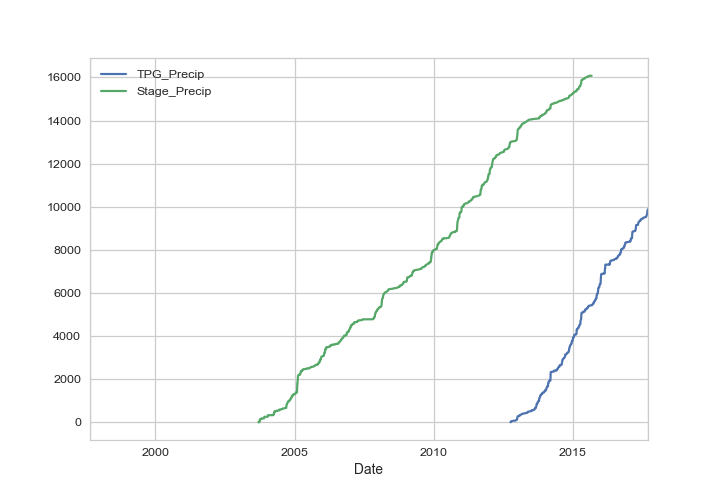

In [6]:
daily_dat[['TPG_Precip', 'Stage_Precip']].cumsum().plot()

In [7]:
#Store precip and related data
precip_cols=['Stage_Precip', 'TPG_Precip']
precip_dat=daily_dat[precip_cols]
precip_related_dat=daily_dat[['Temp_USGS','WindSpeed']]
precip_dat=precip_dat[start_good_overlap_precip_date:last_stage_date] #day after wind screen was repaired to final configuration at TPG 

In [8]:
print(start_good_overlap_precip_date)
last_stage_date

2013-08-28


Timestamp('2015-09-01 00:00:00')

In [9]:
# #Add temperature and wind speed to data
wx_dat=precip_dat.merge(precip_related_dat, left_index=True, right_index=True, how='left')

# #Define precip phase
#wx_dat=wx.define_precip_phase(wx_dat, 'Temp_USGS')

In [10]:
precip_cols=['Stage_Precip', 'TPG_Precip']
total_precip=wx_dat[precip_cols].sum()
scale_factor=total_precip['TPG_Precip']/total_precip['Stage_Precip']
precip_dat['stage_adjusted']=precip_dat.Stage_Precip*scale_factor
print(scale_factor)

2.39345559897


<IPython.core.display.Javascript object>


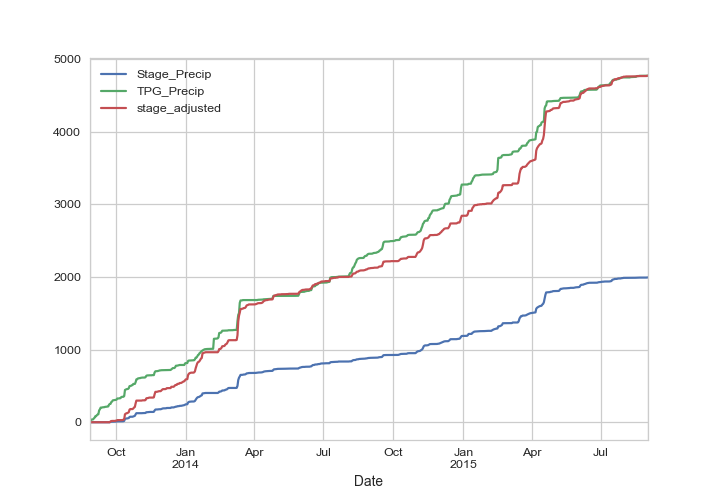

In [11]:
precip_dat.cumsum().plot()

In [15]:
daily_dat['Adjusted_Stage']=daily_dat.Stage_Precip* scale_factor

In [16]:
add_to_TPG=daily_dat.Adjusted_Stage.cumsum()[start_good_overlap_precip_date]#-858#-65212 need that for Wolverine
#add_to_TPG=20642 #reading of TPG on 2014-07-23

In [19]:
add_to_TPG

33277.518741989028

In [28]:
daily_dat['TPG_Precipitation']=daily_dat.TPG_Precip #create copy just to plot overlap
daily_dat.loc[dat.index<pd.to_datetime(start_good_overlap_precip_date), 'TPG_Precipitation']=pd.np.nan #set to NAN before overlap starts
daily_dat.loc[daily_dat.TPG_Precip.first_valid_index(), 'TPG_Precipitation']=add_to_TPG

<IPython.core.display.Javascript object>


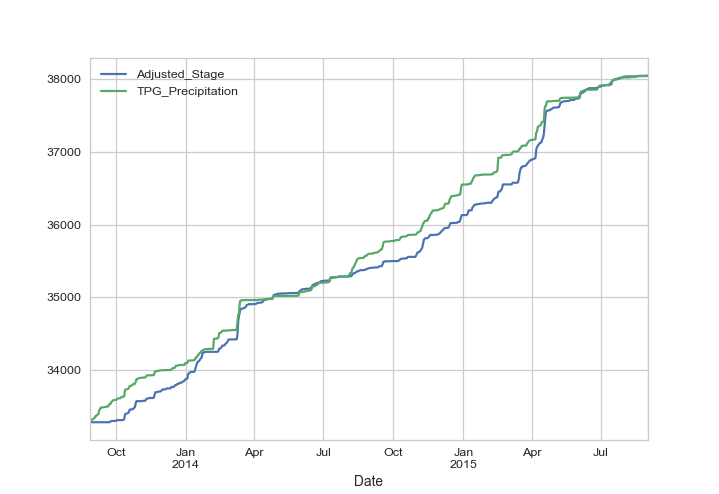

In [34]:
daily_dat[['Adjusted_Stage', 'TPG_Precipitation']].cumsum()[start_good_overlap_precip_date:last_stage_date].plot()
if save_plots:
    plt.savefig(os.curdir+r'/figs//precip_match//Adjusted_Stage_And_TPG_Precip.jpg')

In [35]:
daily_dat['year']=daily_dat.index.year
daily_dat['month']=daily_dat.index.month

In [36]:
monthly_dat=daily_dat.resample('M').sum()

In [37]:
monthly_dat['year']=monthly_dat.index.year
monthly_dat['month']=monthly_dat.index.month

In [38]:
monthly_dat.head()

,Temp_min,Temp_max,Temp_WMO,Temp_USGS,Stage_Precip,TPG_Precip,RelHum,WindSpeed,WindGustSpeed,RadiationIn,RadiationOut,SnowDepth,WindDir,VecAvgWindDir,Adjusted_Stage,TPG_Precipitation,year,month
Date,,,,,,,,,,,,,,,,,,
1997-08-31,18.6,32.7,25.7,26.0,NaN,NaN,NaN,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,8
1997-09-30,120.1,248.5,184.4,178.6,NaN,NaN,NaN,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,9
1997-10-31,-120.1,17.4,-51.4,-53.2,NaN,NaN,NaN,170.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,10
1997-11-30,-142.3,-38.3,-90.4,-82.1,NaN,NaN,NaN,237.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,11
1997-12-31,-309.9,-142.7,-226.3,-217.8,NaN,NaN,NaN,233.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,12


In [39]:
monthly_dat.reset_index(inplace=True)

In [40]:
monthly_melt=pd.melt(monthly_dat[['Adjusted_Stage', 'TPG_Precipitation', 'Date', 'year', 'month']], id_vars=['Date', 'year', 'month'])

In [41]:
monthly_melt.head()

,Date,year,month,variable,value
0,1997-08-31,1997,8,Adjusted_Stage,NaN
1,1997-09-30,1997,9,Adjusted_Stage,NaN
2,1997-10-31,1997,10,Adjusted_Stage,NaN
3,1997-11-30,1997,11,Adjusted_Stage,NaN
4,1997-12-31,1997,12,Adjusted_Stage,NaN


In [42]:
monthly_melt.loc[monthly_melt.value>1000, 'value']=pd.np.nan

<IPython.core.display.Javascript object>


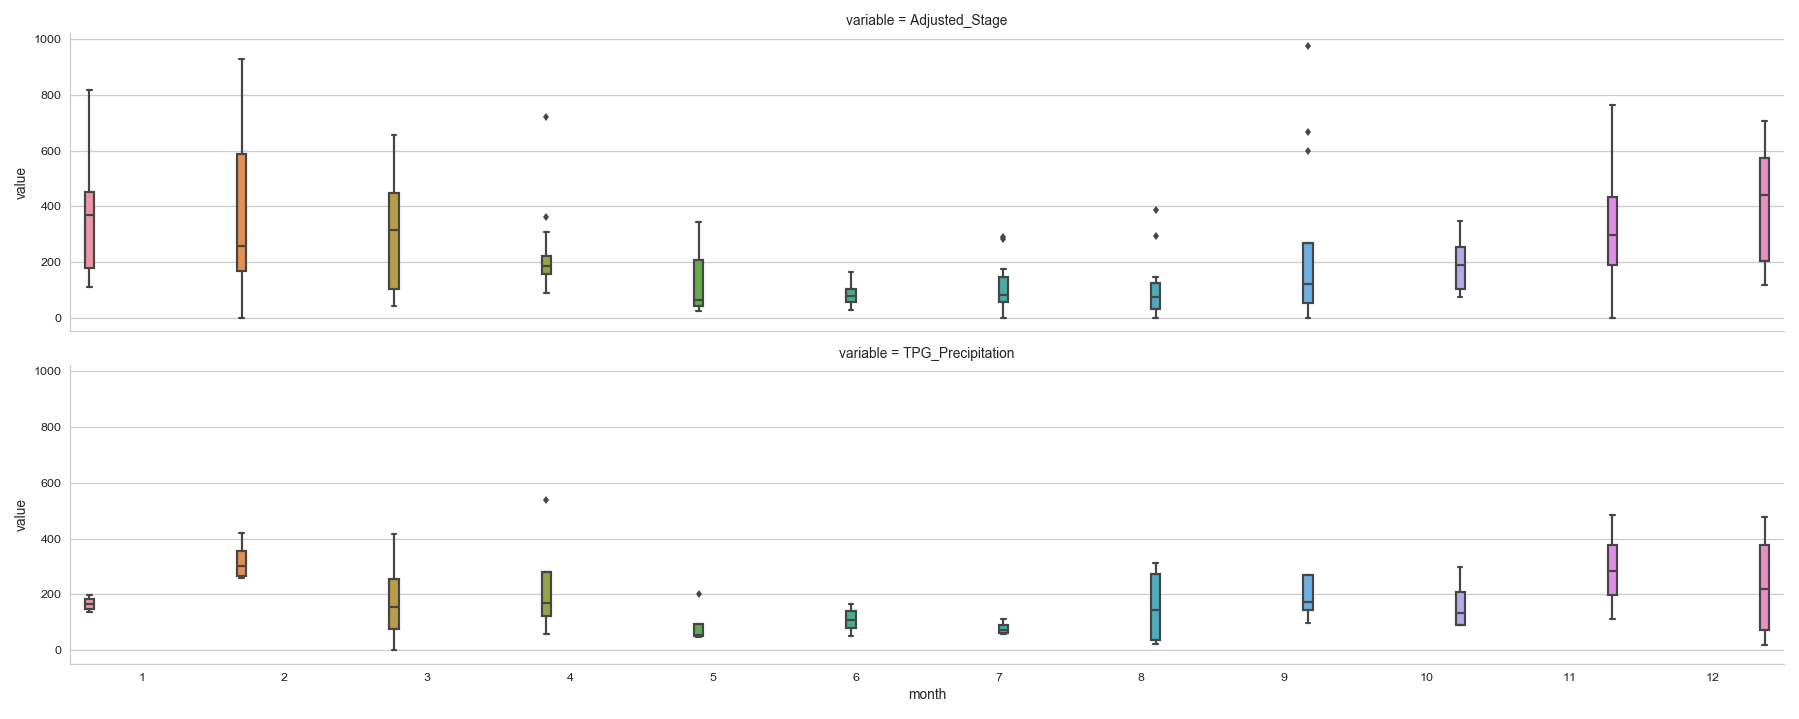

In [44]:
g=sns.factorplot(x='month', y='value', hue='month', row='variable', data=monthly_melt, kind='box', aspect=5)
plt.savefig(os.curdir+r'/figs//precip_match//Monthly_Patterns_of_Precip_for_TPG_And_Stage.jpg')

<IPython.core.display.Javascript object>


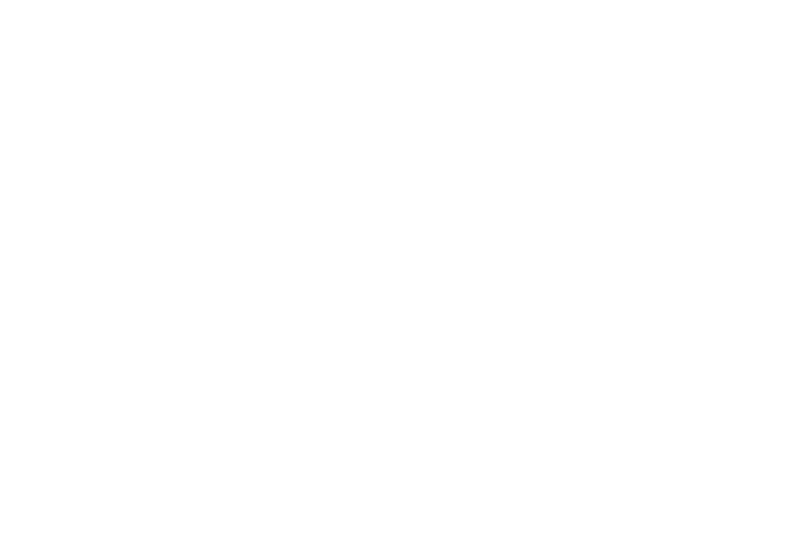

<IPython.core.display.Javascript object>


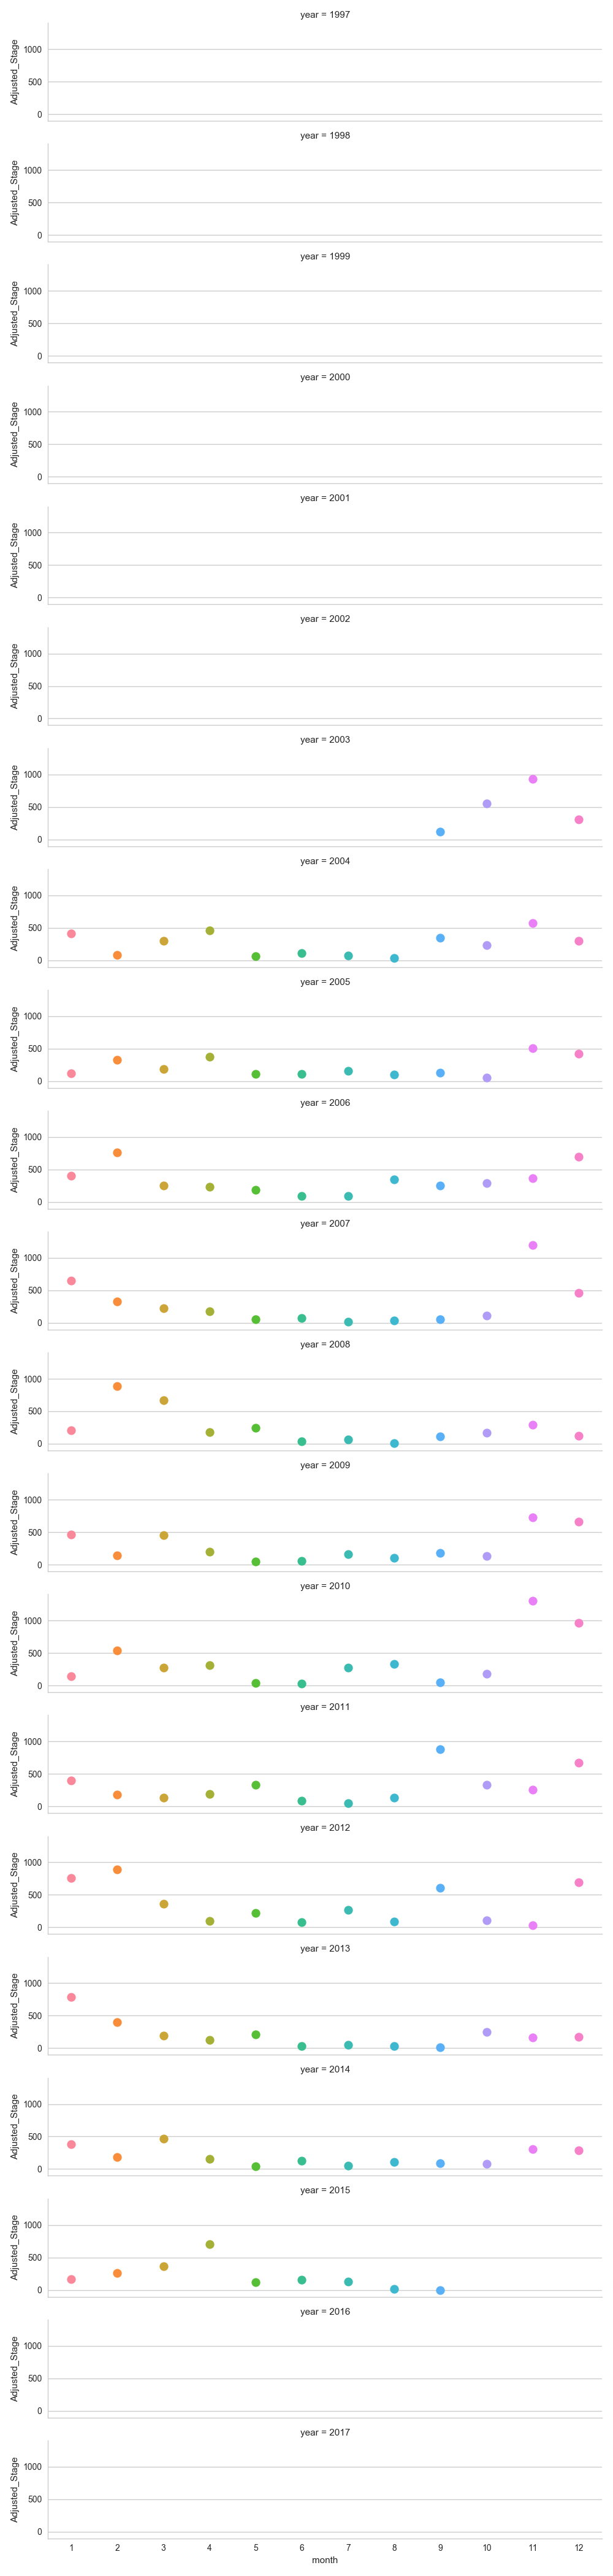

In [24]:
plt.figure()
sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
#g=sns.boxplot(x="year", y='Stage_Precip', data=monthly_dat)
g=sns.factorplot(x='month', y='Adjusted_Stage', hue='month', row='year', data=monthly_dat, kind='point', aspect=5, size=2, width=8)

<IPython.core.display.Javascript object>


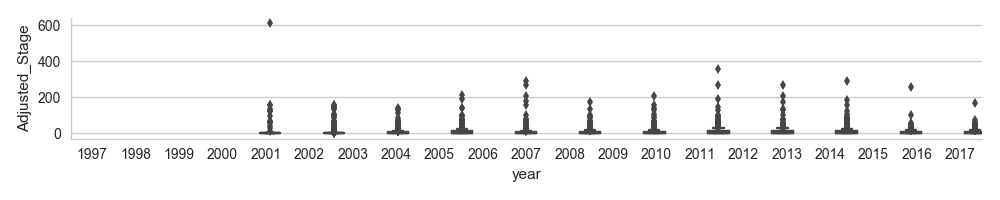

In [25]:
g=sns.factorplot(x='year', y='Adjusted_Stage', hue='year', data=daily_dat, kind='box', aspect=5, size=2, width=10)

In [26]:
precip_dat=precip_dat.dropna(how='all') #drop days where both are NAN

<IPython.core.display.Javascript object>


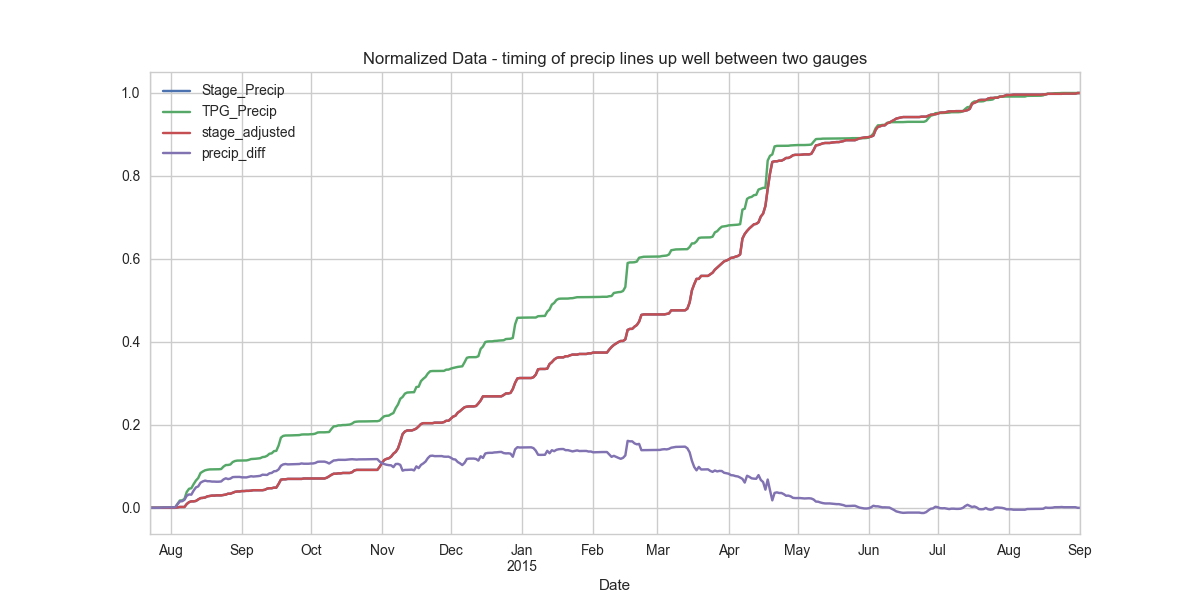

In [27]:
#Normalize data
precip_dat_norm=(precip_dat.cumsum()-precip_dat.cumsum().min())/(precip_dat.cumsum().max()-precip_dat.cumsum().min())
precip_dat_norm['precip_diff']=precip_dat_norm.TPG_Precip-precip_dat_norm.Stage_Precip
precip_dat_norm.plot()
plt.title("Normalized Data - timing of precip lines up well between two gauges")

<IPython.core.display.Javascript object>


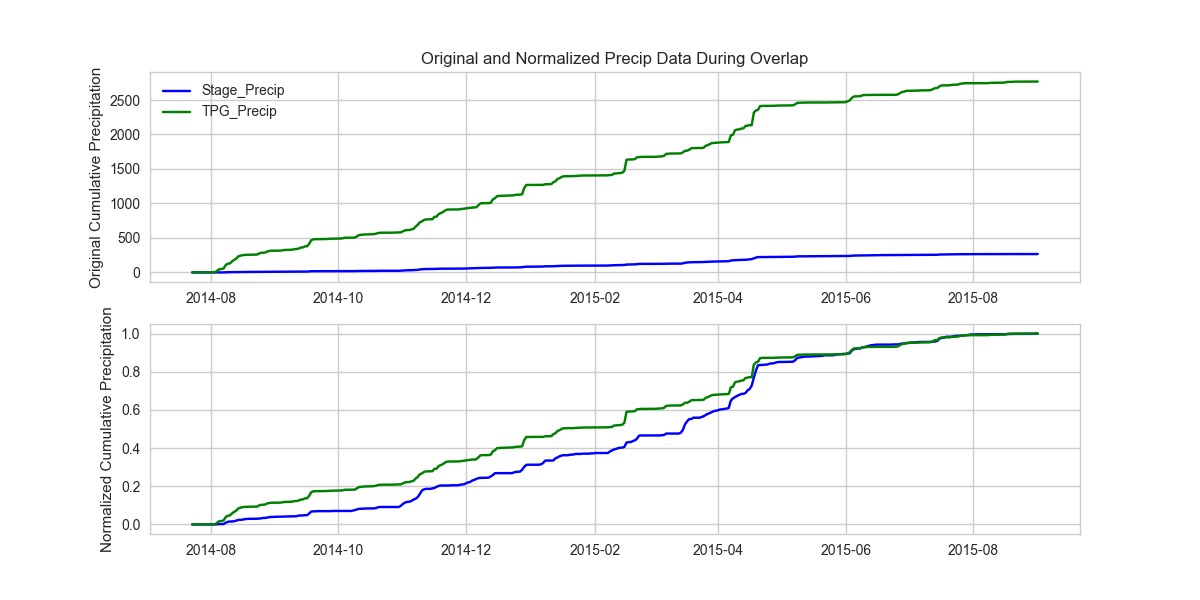

In [28]:
#Plot Cumulative Timeseries to see the problem
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(precip_dat.index, precip_dat[precip_cols[0]].cumsum(),'blue')
plt.plot(precip_dat.index, precip_dat[precip_cols[1]].cumsum(), 'green')
plt.title('Original and Normalized Precip Data During Overlap')
plt.ylabel('Original Cumulative Precipitation')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(precip_dat_norm.index, precip_dat_norm[precip_cols[0]], 'blue')
plt.plot( precip_dat_norm.index, precip_dat_norm[precip_cols[1]],'green')
plt.ylabel('Normalized Cumulative Precipitation')
plt.show()
if save_plots:
    plt.savefig(os.curdir+r'/figs//precip_match//doubleplot_precip_record.jpg')

In [29]:
save_plots=False
robust=False

<IPython.core.display.Javascript object>


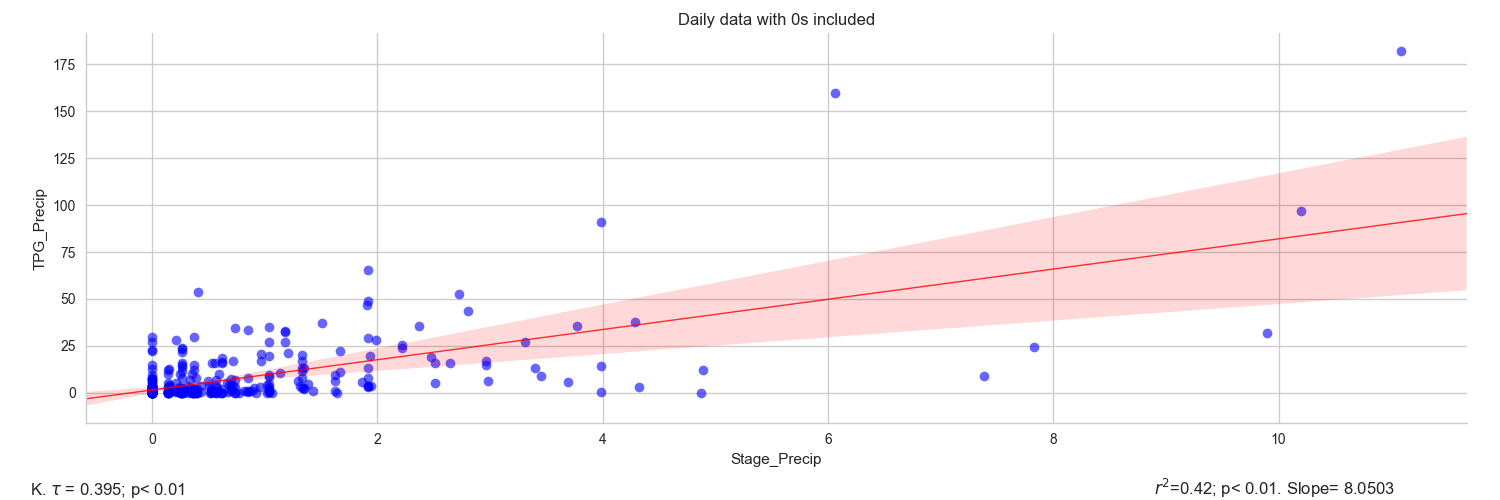

In [30]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=wx_dat, robust=robust)
plt.title("Daily data with 0s included")
if save_plots:
    plt.savefig("./figs/precip_match/Daily data with 0s included lm robust=" +str(robust) +".jpg")

<IPython.core.display.Javascript object>


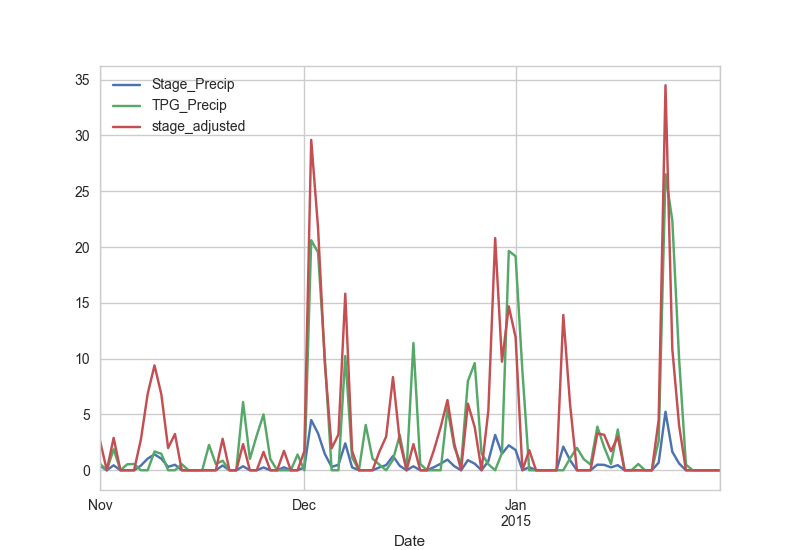

In [44]:
#Plot individual days to see how well precipitation measurements line up
precip_dat['2014-11': '2015-01'].plot()
if save_plots:
    plt.savefig("./figs/precip_match/IndividualPrecipEventsLineUp.jpg")

In [16]:
#Keep no-precip days; smooth record with running mean

In [17]:
precip_dat_7=wx_dat.rolling(7).mean()

<IPython.core.display.Javascript object>


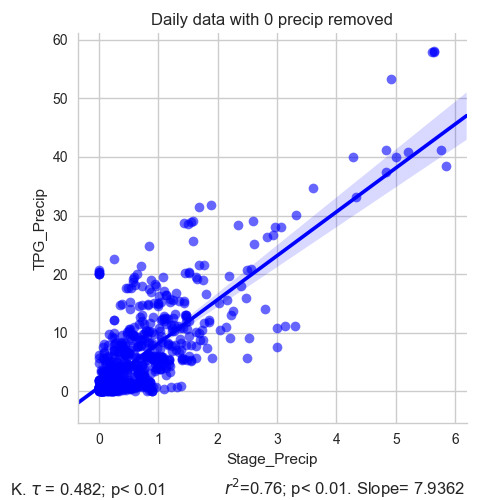

In [18]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=precip_dat_7, robust=robust)
plt.title("Daily data with 0 precip removed")
if save_plots:
    plt.savefig("./figs/precip_match/7-day rolling mean LM robust=" +str(robust) +".jpg")

In [45]:
precip_dat['final_difference']=abs(precip_dat.TPG_Precip-precip_dat.Stage_Precip)

In [46]:
to_plot=precip_dat.final_difference[precip_dat.final_difference>50]

In [47]:
fig=plt.figure()
ax = fig.add_subplot(111)
ln1=plt.plot(precip_dat.stage_adjusted.cumsum())
ln2=plt.plot(precip_dat.Stage_Precip.cumsum())
ln3=plt.plot(precip_dat.TPG_Precip.cumsum())
ln4=ax.plot(to_plot.index,precip_dat.stage_adj.cumsum()[to_plot.index] , 'c^')
lns = ln1+ln2+ln3 +ln4
labs = [l.get_label() for l in lns]
labs[3]="adjusted stage > 50 mm from TPG"
ax.legend(lns, labs, loc=0)
if save_plots:
    plt.savefig("./figs/precip_match/Adjusted_Precip_Using_Scale_Factor.jpg")

<IPython.core.display.Javascript object>

AttributeError: 'DataFrame' object has no attribute 'stage_adj'

In [311]:
mean_diff

8.492665696019973e-16

In [171]:
mean_diff=final_diff.mean()
mean_diff_annotate=plot_funcs.pretty_p_val(mean_diff).split("p")[-1]

<IPython.core.display.Javascript object>


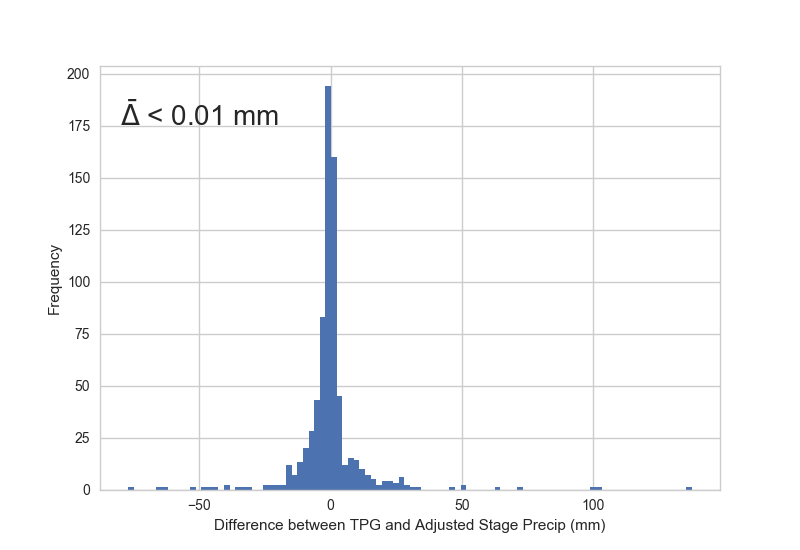

In [179]:
plt.figure()
final_diff=precip_dat.TPG_Precip-precip_dat.stage_adjusted
mean_diff=final_diff.mean()
final_diff.plot(kind='hist', bins=100)
plt.xlabel("Difference between TPG and Adjusted Stage Precip (mm)")
plt.text(-80, 175, r'$\bar \Delta$ ' + mean_diff_annotate + " mm", size=20)
if save_plots:
    plt.savefig("./figs/precip_match/Histogram of difference between Adjusted Stage and TPG.jpg")

## Remove 0 precip days from dataset

In [21]:
#Removing 0s from the dataset
precip_dat_no0=wx_dat.copy()
for col in precip_cols:
    precip_dat_no0.loc[precip_dat[col]==0]=pd.np.nan

<IPython.core.display.Javascript object>


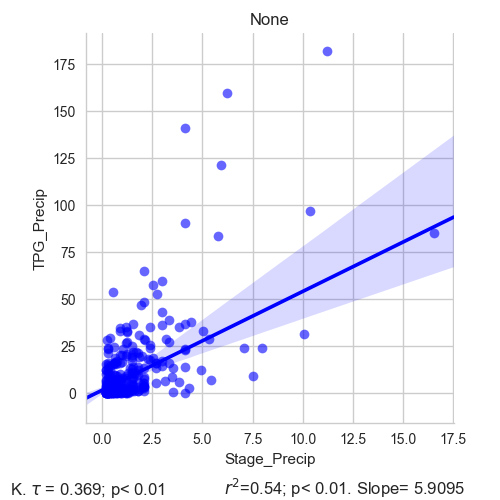

In [22]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=precip_dat_no0, robust=robust)
if save_plots:
    plt.savefig("./figs/precip_match/Daily data WITHOUT 0s included lm robust=" +str(robust) +".jpg")

In [23]:
#Identify cutoff values for high, medium, and low precip days
trace_stage=0.5
trace_tpg=5
high_stage=1.0
high_tpg=10

In [24]:
#Create precipitation intensity bins: high, medium, and low precip labels
wx_dat['precip_rate']=pd.np.nan
wx_dat.loc[(wx_dat.Stage_Precip<trace_stage)| (wx_dat.TPG_Precip<trace_tpg), 'precip_rate']='trace'
wx_dat.loc[(wx_dat.Stage_Precip>high_stage)| (wx_dat.TPG_Precip>high_tpg), 'precip_rate']='heavy'
wx_dat.loc[(wx_dat.Stage_Precip>trace_stage) & (wx_dat.Stage_Precip<high_stage) | (wx_dat.TPG_Precip>trace_tpg) & (wx_dat.TPG_Precip<high_tpg), 'precip_rate']='medium'


In [25]:
# #Plot of Medium precip
# col_y=precip_cols[1]
# col_x=precip_cols[0]
# g=sns.lmplot(col_x, col_y, data=mid_dat, hue='phase', scatter_kws={'alpha':0.7}, legend=False)
# plt.hlines(y=trace_tpg, xmin=0, xmax=1000, linestyles='dotted')
# plt.hlines(y=high_tpg, xmin=0, xmax=1000, linestyles='dotted')

# plt.vlines(x=trace_stage, ymin=0, ymax=42, linestyles='dotted')
# plt.vlines(x=high_stage, ymin=0, ymax=42, linestyles='dotted')
# plt.suptitle("Middle")
# #Add Legend to right side of figure
# box = g.ax.get_position() # get position of figure
# g.ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
# g.ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
# sns.plt.show(g)

<IPython.core.display.Javascript object>


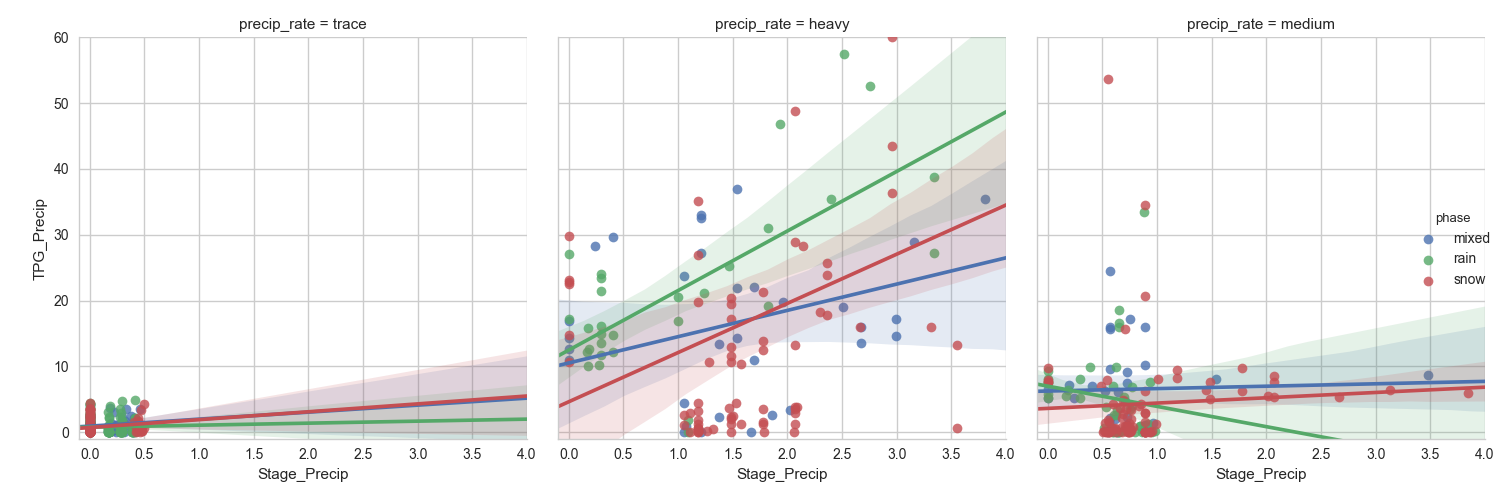

In [32]:
col_y=precip_cols[1]
col_x=precip_cols[0]
g=sns.lmplot(col_x, col_y, data=wx_dat, hue='phase', col='precip_rate', legend_out = True, robust=robust)
g=g.set(ylim=(-1, 60))
g=g.set(xlim=(-0.1,4))
if save_plots:
    plt.savefig("./figs/precip_match/SeparatedByAmount_ColoredByPrecip robust=" +str(robust) +".jpg")

<IPython.core.display.Javascript object>


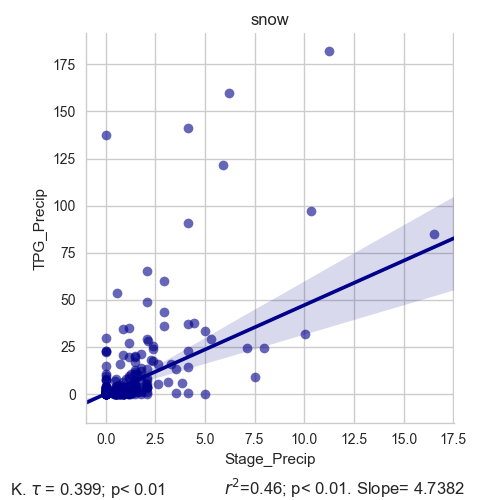

In [26]:
plot_funcs.OLS_plot(col_x, col_y, dat=wx_dat[wx_dat.phase=='snow'], robust=robust, title='snow', color='darkblue')
if save_plots:
    plt.savefig("./figs/precip_match/Snow_regression robust=" +str(robust) +".jpg")

<IPython.core.display.Javascript object>


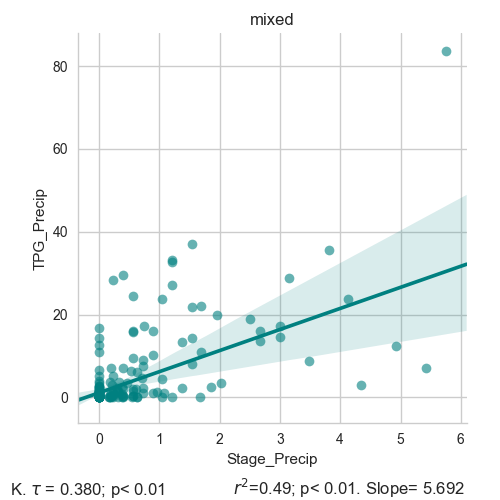

In [27]:
plot_funcs.OLS_plot(col_x, col_y, dat=wx_dat[wx_dat.phase=='mixed'], robust=robust, title='mixed', color='teal')
if save_plots:
    plt.savefig("./figs/precip_match/Mixed_regression robust=" +str(robust) +".jpg")

<IPython.core.display.Javascript object>


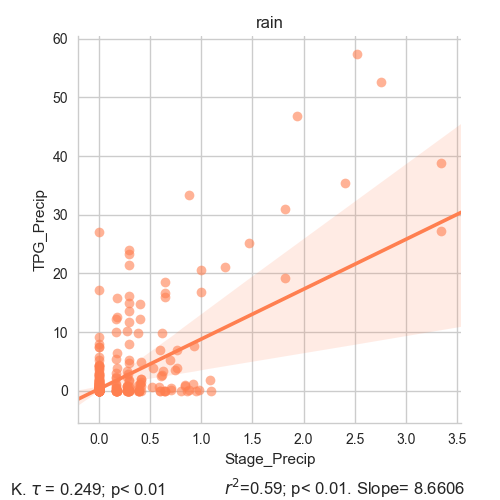

In [28]:
plot_funcs.OLS_plot(col_x, col_y, dat=wx_dat[wx_dat.phase=='rain'], robust=robust, title='rain', color='coral')
if save_plots:
    plt.savefig("./figs/precip_match/Rain_regression robust=" +str(robust) +".jpg")

<IPython.core.display.Javascript object>


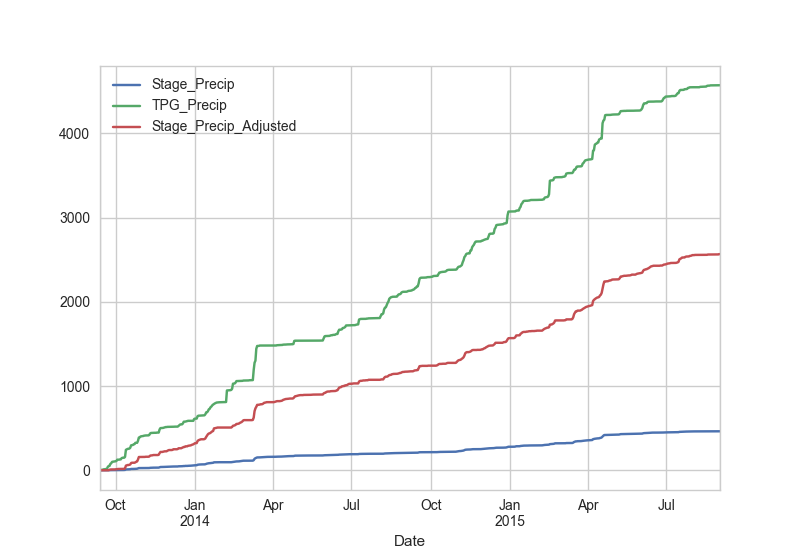

In [180]:
#Adjust precip by these phase-specific factors found above; plot results
wx_dat['Stage_Precip_Adjusted']=pd.np.nan
wx_dat.loc[wx_dat.phase=='snow', 'Stage_Precip_Adjusted']=wx_dat.loc[wx_dat.phase=='snow', 'Stage_Precip']*4.7
wx_dat.loc[wx_dat.phase=='mixed', 'Stage_Precip_Adjusted']=wx_dat.loc[wx_dat.phase=='mixed', 'Stage_Precip']*5.7
wx_dat.loc[wx_dat.phase=='rain', 'Stage_Precip_Adjusted']=wx_dat.loc[wx_dat.phase=='rain', 'Stage_Precip']*8.9

wx_dat[precip_cols+['Stage_Precip_Adjusted']].cumsum().plot()
if save_plots:
    plt.savefig("./figs/precip_match/Cumulative_Precip_AfterAdjustment.jpg")

9.8823099775444572

In [30]:
wx_dat.precip_diff.mean()

5.669850582304199

In [29]:
#I'm working here to identify where the main problem is - useding binning to look at WHERE most of the difference (bulk) comes from - group by precip amount,e
#i.e. is it many light precip days or fewer heavy precip days that are giving the most cumulative difference

In [29]:
wx_dat['precip_diff']=wx_dat.TPG_Precip-wx_dat.Stage_Precip

In [60]:
wx_dat
bins=[0]+list(range(1,20))+[30, 40, 50, 60]
wx_dat['bins']=0
for x in bins:
    wx_dat.loc[wx_dat.precip_diff>=x, 'bins']=x
wx_dat.loc[wx_dat.bins==30, 'bins']='30-40'
wx_dat.loc[wx_dat.bins==40, 'bins']='40-50'
wx_dat.loc[wx_dat.bins==50, 'bins']='50-60'

In [68]:
diffdat=wx_dat[wx_dat.TPG_Precip>wx_dat.Stage_Precip].copy() #days where TPG is bigger than Stage Gage
diffdat['precip_diff']=diffdat.TPG_Precip-diffdat.Stage_Precip

In [64]:
s.index

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19, '30-40', '40-50', '50-60'],
      dtype='object', name='bins')

       Stage_Precip  TPG_Precip    diff
bins                                   
0             33.46       122.5   89.04
1             15.03       116.5  101.47
2             13.36       110.6   97.24
3              8.35        86.0   77.65
4              8.62        75.1   66.48
5             11.86       108.8   96.94
6              6.97       104.5   97.53
7              9.39       108.3   98.91
8              6.42        66.2   59.78
9              4.43        89.3   84.87
10             1.99        53.8   51.81
11             5.56        96.5   90.94
12             5.58        80.2   74.62
13             5.45       100.3   94.85
14             3.52        61.4   57.88
15             3.11        50.2   47.09
16             1.56        50.5   48.94
17             1.16        35.6   34.44
18             0.46        36.7   36.24
19            25.48       414.0  388.52
30-40          6.66       147.6  140.94
40-50          9.34       239.9  230.56
50-60          5.80       115.7  109.90


<IPython.core.display.Javascript object>


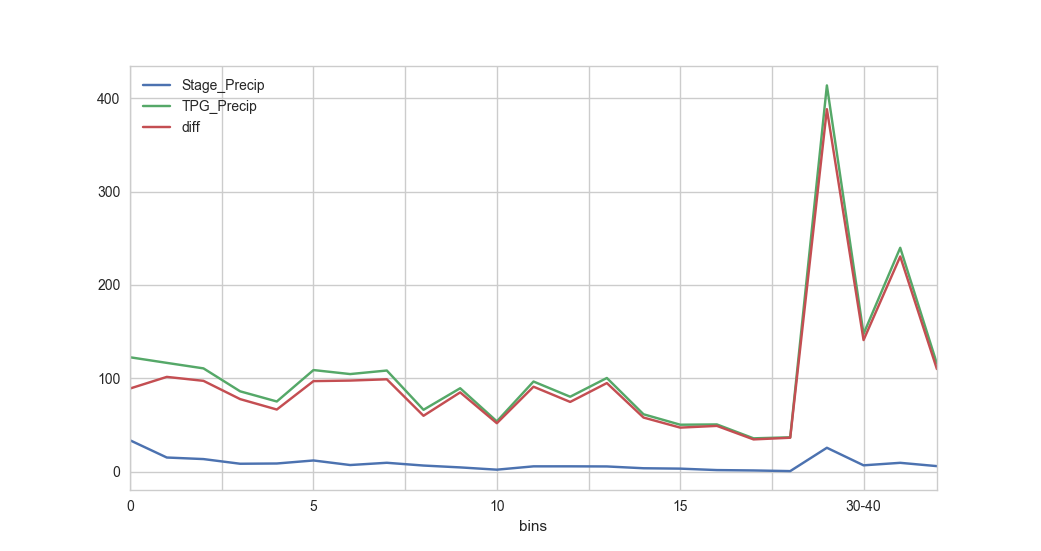

In [67]:
s = diffdat[precip_cols+['diff', 'bins']].groupby('bins').sum()
print(s)
ax=s.plot()
#ax.set_xticks(bins)
#ax.set_xticklabels(s.index)

In [74]:
wx_dat['precip_diff']=abs(wx_dat.TPG_Precip-wx_dat.Stage_Precip)
difference_cutoff=wx_dat.precip_diff.quantile(0.95)
difference_cutoff

15.852

In [79]:
n_drop=len(wx_dat.loc[wx_dat.precip_diff>difference_cutoff, precip_cols])
print("dropping "+ str(n_drop) + "; difference is over 95th percentile of "+ str(difference_cutoff))

dropping 36; difference is over 95th percentile of 15.852


In [81]:
wx_dat.loc[wx_dat.TPG_Precip>wx_dat.TPG_Precip.quantile(.95), 'TPG_Precip']=pd.np.nan

<IPython.core.display.Javascript object>


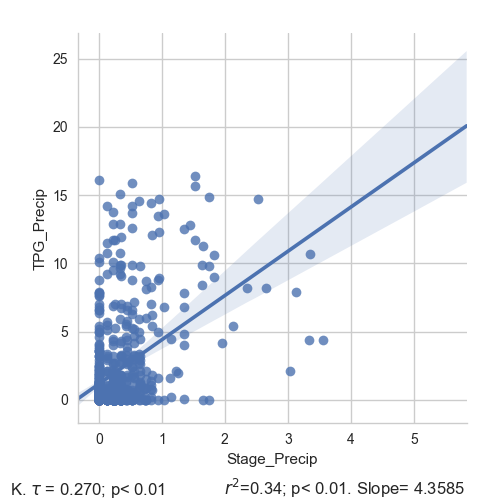

In [82]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=wx_dat)

<IPython.core.display.Javascript object>


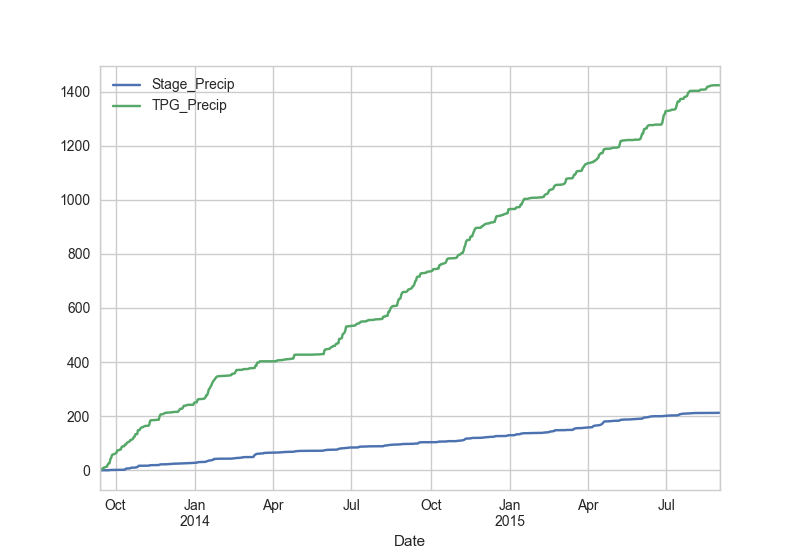

In [73]:
wx_dat[precip_cols].cumsum().plot()

<IPython.core.display.Javascript object>


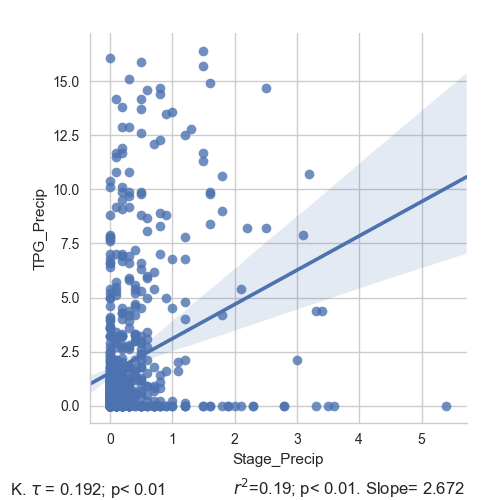

In [82]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=wx_dat)

In [47]:
wx_dat['precip_diff']=wx_dat.TPG_Precip-wx_dat.Stage_Precip

<IPython.core.display.Javascript object>


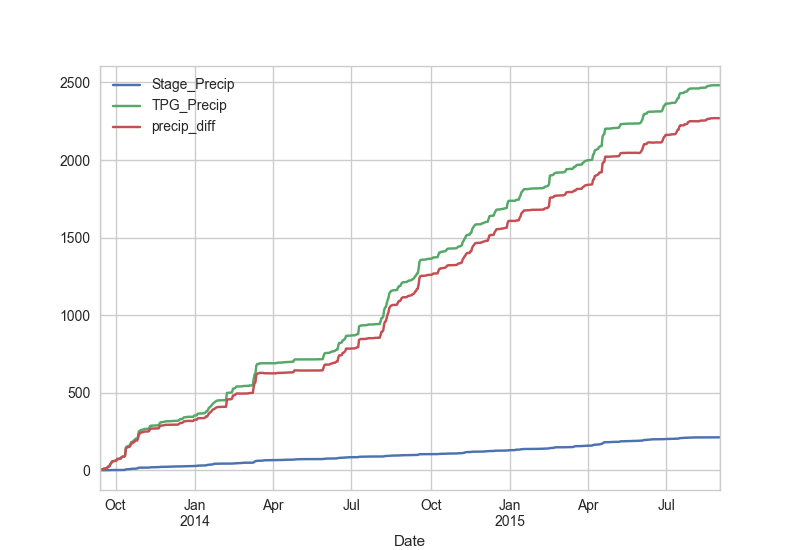

In [57]:
wx_dat[precip_cols + ['precip_diff']].cumsum().plot()

In [66]:
wx_dat.columns

Index(['Stage_Precip', 'TPG_Precip', 'Temp_USGS', 'WindSpeed', 'precip_rate',
       'phase', 'bins', 'diff', 'precip_diff'],
      dtype='object')

In [67]:
col_x='Stage_Precip'
col_y='TPG_Precip'
col_w="WindSpeed"
lm1=sm.ols(col_y + '~' + col_x, data=wx_dat).fit() #simple OLS
lm2=sm.ols(col_y + '~' + col_x + "+ " + col_w, data=wx_dat).fit() #Multiple regression with wind

In [68]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TPG_Precip   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     399.0
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           6.55e-71
Time:                        11:40:59   Log-Likelihood:                -2297.0
No. Observations:                 719   AIC:                             4598.
Df Residuals:                     717   BIC:                             4607.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        1.1637      0.249      4.683      0.000         0.676     1.652
Stage_Precip     7.7461      0.388     19.974      0.000         6.985     8.507
==============================================================================
Omnibus:                      474.372   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7855.819
Skew:                           2.708   Prob(JB):                         0.00
Kurtosis:                      18.261   Cond. No.                         1.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TPG_Precip   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     321.3
Date:                Tue, 06 Feb 2018   Prob (F-statistic):          2.60e-100
Time:                        11:41:22   Log-Likelihood:                -2225.8
No. Observations:                 719   AIC:                             4458.
Df Residuals:                     716   BIC:                             4471.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -2.2002      0.351     -6.277      0.000        -2.888    -1.512
Stage_Precip     5.9776      0.379     15.781      0.000         5.234     6.721
WindSpeed        0.5866      0.047     12.525      0.000         0.495     0.679
==============================================================================
Omnibus:                      403.612   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4866.004
Skew:                           2.271   Prob(JB):                         0.00
Kurtosis:                      14.908   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
#F-test (ANOVA) indicates that adding wind speed does improve model performance significantly
f_val, p_val, df_diff=lm2.compare_f_test(lm1)
p_val

1.1070481461226498e-32

<IPython.core.display.Javascript object>


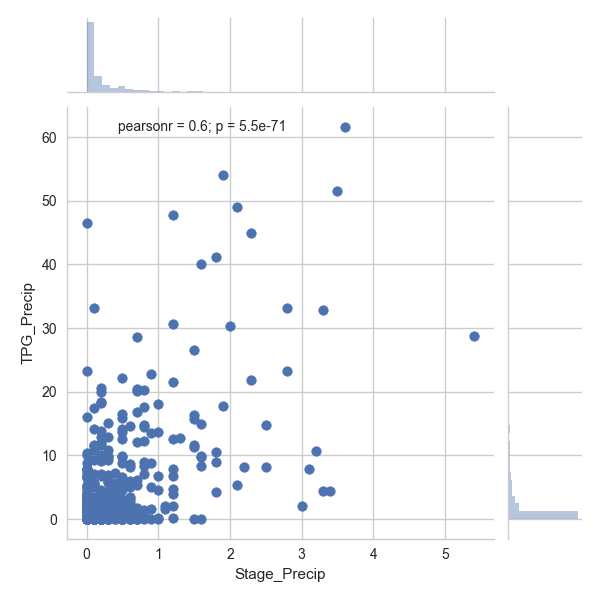

In [46]:
sns.jointplot(col_x, col_y, data=all_dat, stat_func=kend)

<IPython.core.display.Javascript object>


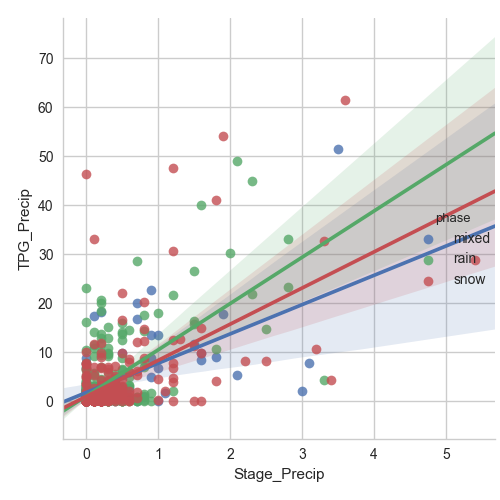

In [53]:
g=sns.lmplot(col_x, col_y, data=all_dat, hue='phase')


In [57]:
all_dat.columns

Index(['Stage_Precip', 'TPG_Precip', 'Temp_USGS', 'WindSpeed', 'phase',
       'precip_rate'],
      dtype='object')

<IPython.core.display.Javascript object>


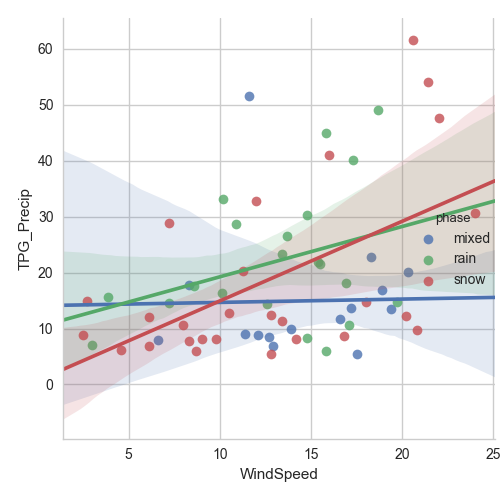

In [67]:
g=sns.lmplot('WindSpeed', col_y, data=all_dat[(all_dat.WindSpeed>1) & (all_dat.TPG_Precip>trace_tpg) 
                                              & (all_dat.Stage_Precip>trace_stage)], hue='phase')


In [ ]:
#Do cumulaive sum plots to see WHERE all the difference in the cumulative timeseries is coming from
#Is it mainly on BIG precip days? Or just the little guys, where TPG picks up a lil bit and stage misses all?
#UGHHH
#Need to phone a friend for #help
#Git Add this